In [70]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os


#### Loading Data

In [71]:
# Check if data is already there and only download if it isnt
if not os.path.exists('optdigits.tra') and not os.path.exists('optdigits.tes'):

    # URLs for the dataset
    train_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
    test_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"

    urllib.request.urlretrieve(train_url, 'optdigits.tra') # training data
    urllib.request.urlretrieve(test_url, 'optdigits.tes') # test data

In [72]:
# load the data and normalize it
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    inputs = (data[:, :-1] - 8) / 8.0 # Normalize the inputs between -1 and 1
    targets = np.eye(10)[data[:, -1].astype(int)]  # One-hot encoding
    return list(zip(inputs, targets))

# Load the training and test data
train_data = load_data('optdigits.tra')
test_data = load_data('optdigits.tes')

In [73]:
# sanity check
train_data[0]

(array([-1.   , -0.875, -0.25 ,  0.875,  0.5  , -0.875, -1.   , -1.   ,
        -1.   , -0.125,  1.   , -0.25 , -0.25 ,  0.25 , -1.   , -1.   ,
        -1.   ,  0.   ,  1.   , -0.75 , -1.   ,  0.375, -0.75 , -1.   ,
        -1.   , -0.375,  1.   , -0.625, -1.   , -0.375, -0.125, -1.   ,
        -1.   , -0.125,  0.625, -0.625, -1.   ,  0.   , -0.125, -1.   ,
        -1.   , -0.5  ,  0.5  , -1.   , -0.875,  0.625, -0.375, -1.   ,
        -1.   , -1.   ,  0.75 ,  0.125,  0.875,  0.125, -1.   , -1.   ,
        -1.   , -1.   , -0.25 ,  0.75 , -0.125, -0.875, -1.   , -1.   ]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

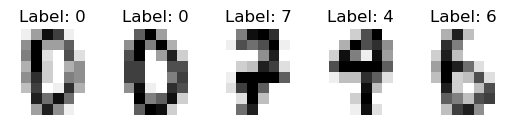

In [74]:
# a visualization of the a small sample of the data

# Function to draw images
def draw_images(data, num_images):
    for index, (image, label) in enumerate(data[:num_images]):
        plt.subplot(1, num_images, index + 1)
        plt.axis('off')
        plt.imshow(image.reshape((8,8)), cmap=plt.cm.gray_r)
        label = np.argmax(label)
        plt.title('Label: %i' % label, fontsize = 12)
    plt.show()

# Draw some images from the training data
draw_images(train_data, 5)

In [75]:
# data generator that yields minibatches from the data of a given size
def data_generator(data, minibatch_size):
    np.random.shuffle(data)
    for i in range(0, len(data), minibatch_size):
        minibatch = data[i:i+minibatch_size]
        inputs = np.array([item[0] for item in minibatch])
        targets = np.array([item[1] for item in minibatch])
        yield inputs, targets

# Check the data generator
train_data_gen = data_generator(train_data, 10)
inouts, outouts = next(train_data_gen)
print(inouts.shape, outouts.shape)

(10, 64) (10, 10)


#### 2.2, 2.3 Activation Functions

In [76]:
class Module:
    """Abstract module class that NN are composed off"""
    def __call__(self, input):
        # Forward pass/inference
        raise NotImplementedError
    
    def back(self, grad):
        # Backward pass/derivative
        raise NotImplementedError

    def parameters(self):
        # Return list of parameters
        return []
    
    def __str__(self):
        return self.__class__.__name__ + '()'

In [77]:
class Sigmoid(Module):
    """Sigmoid activation function"""
    def __call__(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def back(self, grad):
        return grad * self.output * (1 - self.output)
    
    def __str__(self):
        return self.__class__.__name__
    
class Softmax(Module):
    """Softmax activation function"""
    def __call__(self, input):
        exp = np.exp(input - np.max(input, axis=-1, keepdims=True)) # subtract max to avoid overflow and help with numerical stability
        self.output = exp / np.sum(exp, axis=-1, keepdims=True)
        return self.output
    
    def back(self, grad):
        # here we assume that cross entropy loss is used, so the derivative of both is just the output - target
        # it's more efficient to combine the softmax and cross entropy loss into one function
        # otherwise, we need to calculate the Jacobian matrix of the softmax function as follows below
        return grad 
                    
        # print("output shape: ",self.output.shape) 
        # print("grad shape: ", grad.shape)  
        batch_size = self.output.shape[0]
        num_classes = self.output.shape[1]
        
        # Initialize a 3D Jacobian tensor
        # to deal with handling batches of grads, for each grad in the batch, we need to calculate the Jacobian matrix
        # the Jacobian matrix is a square matrix with the same size as the number of output classes
        jacobian_tensor = np.zeros((batch_size, num_classes, num_classes))
        # print("jacobian_tensor shape: ", jacobian_tensor.shape)
        
        # Calculate the Jacobian matrix for each grad in the batch
        for i in range(batch_size):
            s = self.output[i].reshape(-1, 1)
            jacobian_matrix = np.diagflat(s) - np.dot(s, s.T)
            jacobian_tensor[i] = jacobian_matrix
            # if i == 0:
            #     print("s shape: ", s.shape)
            #     print("jacobian_matrix shape: ", jacobian_matrix.shape)

        
        # Multiply each Jacobian matrix with the corresponding gradient vector to get the vector of partial derivatives of the output with respect to each input
        grad_output = np.empty_like(self.output)
        for i in range(batch_size):
            grad_output[i] = np.dot(jacobian_tensor[i], grad[i])
        
        return grad_output
    
    def __str__(self):
        return self.__class__.__name__
    
class Relu(Module):
    """Relu activation function"""
    def __call__(self, input):
        self.output = np.maximum(0, input) # element-wise relu, 0 if input < 0, otherwise input
        return self.output
    
    def back(self, grad):
        return grad * (self.output > 0) # derevative of relu is 1 if input > 0, otherwise 0
    
    def __str__(self):
        return self.__class__.__name__
    
class Linear(Module):
    """Linear acriavation function"""
    def __call__(self, input):
        self.output = input
        return self.output

    def back(self, grad):
        return grad
    
    def __str__(self):
        return self.__class__.__name__

#### 2.4 Layer

In [78]:
class Parameter:
    """Parameter class for NN parameters"""
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)
        #self.reset()

    def reset(self):
        self.grad = np.zeros_like(self.data)

In [79]:
class Dense(Module):
    """Dense layer"""
    def __init__(self, input_size, output_size, activation:str):
        self.weights = Parameter(np.random.randn(input_size, output_size) * 0.01) # initialization with small random values
        self.bias = Parameter(np.zeros(output_size)) # initialization with zeros
        self.activation = self.set_activation(activation) # set the activation function acording to the input string
        
    def __call__(self, input):
        self.input = input
        self.output = np.dot(input, self.weights.data) + self.bias.data

        self.output = self.activation(self.output)

        return self.output
    
    def back(self, grad):
        grad = self.activation.back(grad) # backpropagate through the activation function first
        
        # calculate the gradients for the weights and bias
        self.weights.grad = np.dot(self.input.T, grad)
        self.bias.grad = np.sum(grad, axis=0)
        return np.dot(grad, self.weights.data.T)
    
    def parameters(self):
        return [self.weights, self.bias]
    
    def set_activation(self, activation):
        if activation == 'relu':
            return Relu()
        elif activation == 'sigmoid':
            return Sigmoid()
        elif activation == 'softmax':
            return Softmax()
        else:
            error_msg = 'Invalid / not implemented activation function: ' + str(activation)
            error_msg += '\nValid activation functions: relu, sigmoid, softmax'
            raise ValueError(error_msg)

    def __str__(self):
        return self.__class__.__name__ + '(in=' + str(self.weights.data.shape[0]) + ', out=' + str(self.weights.data.shape[1]) + str(', activation=' + str(self.activation)) + ')' if self.activation else ')'

#### 2.5 Model

In [80]:
class Model(Module):
    """Simple model"""
    def __init__(self):
        self.set_layers([Dense(64, 32, activation="sigmoid"),
                        Dense(32, 10, activation="softmax")]) # default layers
    
    def __call__(self, input):
        for layer in self.__layers:
            input = layer(input)
        return input
    
    def back(self, grad):
        # backpropagate through all layers in reverse order
        for layer in reversed(self.__layers):
            grad = layer.back(grad)
        return grad
    
    def parameters(self):
        params = []
        for layer in self.__layers:
            params.extend(layer.parameters())
        return params
    
    def zero_grad(self):
        # reset the gradients of all parameters
        for param in self.parameters():
            param.reset()

    def set_layers(self, layers):
        # set the layers of the model
        self.__layers = layers
    
    def __str__(self):
        total_params = sum(np.prod(param.data.shape) for layer in self.__layers for param in layer.parameters())
        return "Model(\n  " + "\n  ".join([str(layer) for layer in self.__layers]) + "\n), Param count: " + str(total_params)

#### 2.6 CCE

In [81]:
class CCE:
    """Categorical cross-entropy loss"""
    
    def __call__(self, y_pred, y_true):
        # Clip prediction to avoid log(0) error
        y_pred = np.clip(y_pred, 1e-9, 1. - 1e-9)
        self.y_pred = y_pred
        self.y_true = y_true
        return -np.sum(y_true * np.log(y_pred))
    
    def back(self):
        return self.y_pred - self.y_true

In [82]:
# test forward pass
model = Model()
cce = CCE()
x, y = next(train_data_gen)
output = model(x)
assert output.shape == (10, 10)

# test backward pass
grad = cce(output, y)
grad = model.back(grad)
assert grad.shape == (10, 64)

In [83]:
print(model)

Model(
  Dense(in=64, out=32, activation=Sigmoid)
  Dense(in=32, out=10, activation=Softmax)
), Param count: 2410


#### 3.6 Training

In [84]:
class Optimizer:
    """Abstract optimizer class"""
    def __init__(self, parameters):
        self.parameters = parameters
    
    def step(self):
        raise NotImplementedError

class SGD(Optimizer):
    """Stochastic gradient descent optimizer"""
    def __init__(self, parameters, lr=1e-2):
        super().__init__(parameters)
        self.lr = lr
    
    def step(self):
        for param in self.parameters():
            param.data -= self.lr * param.grad

In [85]:
# calculate the accuracy of the model on the given data
def accuracy(model, data):
    total = 0
    correct = 0
    for x, y in data:
        output = model(x)
        correct += np.sum(np.argmax(output, axis=-1) == np.argmax(y, axis=-1))
        total += len(x)
    return correct/total

def training_step(model, loss, optimizer, x, y):
    output = model(x)
    loss_result = loss(output, y)
    grad = loss.back()
    model.back(grad)
    optimizer.step()
    model.zero_grad()
    # optimizer.step()
    
    return loss_result

def training_loop(model, loss, optimizer, train_data, test_data, epochs, minibatch_size):
    # lists to collect epoch results
    epoch_accuracies_train = []
    epoch_accuracies_test = []
    epoch_losses = []
    for epoch in range(epochs):
        train_data_gen = data_generator(train_data, minibatch_size)
        
        # Training
        losses = []
        for x, y in train_data_gen:
            loss_result = training_step(model, loss, optimizer, x, y)
            losses.append(loss_result)
        epoch_loss = np.mean(losses)

        # Testing on test data
        test_data_gen = data_generator(test_data, minibatch_size)
        accuracy_test = accuracy(model, test_data_gen)

        # Testing on train data
        train_data_gen = data_generator(train_data, minibatch_size)
        accuracy_train = accuracy(model, train_data_gen)

        # Print epoch results
        print(f'Epoch: {epoch+1}, Accuracy_test: {accuracy_test:.3f}, Accuracy_train: {accuracy_train:.3f}, Loss: {epoch_loss:.3f}')

        # collect epoch results
        epoch_accuracies_test.append(accuracy_test)
        epoch_accuracies_train.append(accuracy_train)
        epoch_losses.append(epoch_loss)

    return epoch_accuracies_test, epoch_accuracies_train, epoch_losses


In [86]:
import matplotlib.pyplot as plt

def plot_training_results(accuracy_test, accuracy_train, losses, max_steps=20):
    # Create a figure and a set of subplots
    epoch_idx = range(1,len(accuracy_test)+1)
    x_ticks = list(range(1, len(accuracy_test) + 1))
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    def plot(ax, data, title, y_label,label, color):
        ax.plot(epoch_idx, data, label=label, color=color)
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(y_label)
        ax.set_xticks(x_ticks)
        ax.legend()
        ax.grid(True)
    
    # Plotting training loss
    plot(axs[0], losses, 'Training Loss Over Epochs', 'Loss', 'Loss Over Epoch ', 'red')
    plot(axs[1], accuracy_test, 'Training Accuracy Over Epochs', 'Accuracy', 'Test Accuracy', 'blue')
    plot(axs[1], accuracy_train, 'Training Accuracy Over Epochs', 'Accuracy', 'Train Accuracy', 'green')
    
    plt.tight_layout()
    plt.show()

In [87]:
# Train the model
model = Model()

# there are 3 configurations, to show different aspects of training
configurations = 1

if configurations == 1: # simple small model, already does the job pretty well
  model.set_layers([Dense(64, 32, activation="sigmoid"),
                  Dense(32, 10, activation="softmax")])
  
elif configurations == 2: # bigger model with ReLU activation, works with lower learning rate(0.01)
  model.set_layers([Dense(64, 256, activation="relu"),
                  Dense(256, 128, activation="relu"),
                    Dense(128, 10, activation="softmax")])
  
elif configurations == 3: # biger model with sigmoid activation, works with higher learning rate(0.1) / more epochs due to sigmoid in the hidden layers 
                          # ( gradient vanishing problem -- >here the gradient already are getting too smal, hence the higher learning rate )

  model.set_layers([Dense(64, 256, activation="sigmoid"),
                    Dense(256, 128, activation="sigmoid"),
                      Dense(128, 10, activation="softmax")])

print(model)

loss = CCE()
optimizer = SGD(model.parameters, lr=1e-2)

accuracy_test, accuracy_train, losses = training_loop(model, loss, optimizer, train_data, test_data, epochs=20, minibatch_size=16)

Model(
  Dense(in=64, out=32, activation=Sigmoid)
  Dense(in=32, out=10, activation=Softmax)
), Param count: 2410
Epoch: 1, Accuracy_test: 0.599, Accuracy_train: 0.589, Loss: 35.089
Epoch: 2, Accuracy_test: 0.873, Accuracy_train: 0.897, Loss: 16.927


Epoch: 3, Accuracy_test: 0.900, Accuracy_train: 0.932, Loss: 7.345
Epoch: 4, Accuracy_test: 0.917, Accuracy_train: 0.950, Loss: 4.498
Epoch: 5, Accuracy_test: 0.928, Accuracy_train: 0.959, Loss: 3.430
Epoch: 6, Accuracy_test: 0.935, Accuracy_train: 0.964, Loss: 2.862
Epoch: 7, Accuracy_test: 0.941, Accuracy_train: 0.969, Loss: 2.497
Epoch: 8, Accuracy_test: 0.942, Accuracy_train: 0.974, Loss: 2.249
Epoch: 9, Accuracy_test: 0.944, Accuracy_train: 0.974, Loss: 2.047
Epoch: 10, Accuracy_test: 0.947, Accuracy_train: 0.975, Loss: 1.900
Epoch: 11, Accuracy_test: 0.947, Accuracy_train: 0.979, Loss: 1.780
Epoch: 12, Accuracy_test: 0.947, Accuracy_train: 0.980, Loss: 1.659
Epoch: 13, Accuracy_test: 0.949, Accuracy_train: 0.978, Loss: 1.573
Epoch: 14, Accuracy_test: 0.949, Accuracy_train: 0.984, Loss: 1.498
Epoch: 15, Accuracy_test: 0.950, Accuracy_train: 0.984, Loss: 1.421
Epoch: 16, Accuracy_test: 0.952, Accuracy_train: 0.984, Loss: 1.360
Epoch: 17, Accuracy_test: 0.955, Accuracy_train: 0.984,

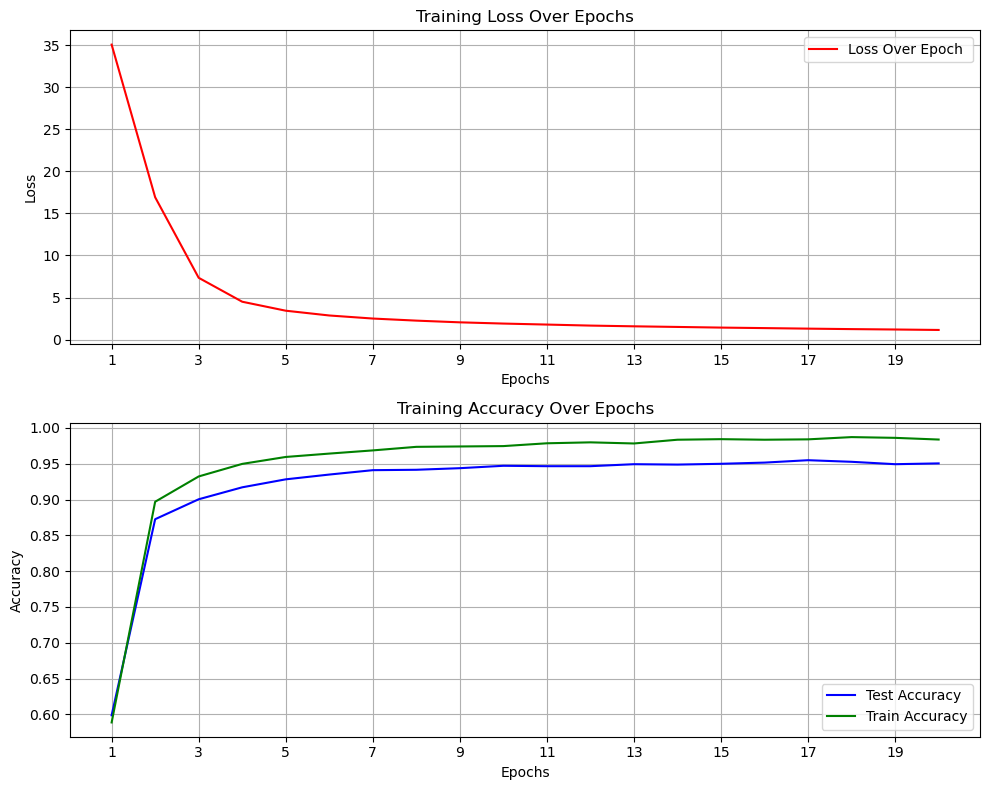

In [88]:
# plot training results
plot_training_results(accuracy_test, accuracy_train, losses)

In [91]:
# show some predictions and the actual targets
test_data_subset = test_data[:10]
for i in range(10):
    pred = model(test_data_subset[i][0])
    print(f"Data point {i+1}:")
    print(f"Prediction: {np.argmax(pred)}")
    print(f"Actual target: {np.argmax(test_data_subset[i][1])}")
    print()

Data point 1:
Prediction: 5
Actual target: 5

Data point 2:
Prediction: 6
Actual target: 6

Data point 3:
Prediction: 8
Actual target: 8

Data point 4:
Prediction: 5
Actual target: 5

Data point 5:
Prediction: 8
Actual target: 8

Data point 6:
Prediction: 0
Actual target: 0

Data point 7:
Prediction: 9
Actual target: 9

Data point 8:
Prediction: 1
Actual target: 1

Data point 9:
Prediction: 3
Actual target: 3

Data point 10:
Prediction: 9
Actual target: 9

